# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    trans = transforms.Compose([transforms.Resize(size=(image_size,image_size)),
                                transforms.ToTensor()])
    
    image_ds = datasets.ImageFolder(data_dir, transform=trans)
    dl = torch.utils.data.DataLoader(image_ds,batch_size,shuffle=True)
    
    
    return dl


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [7]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

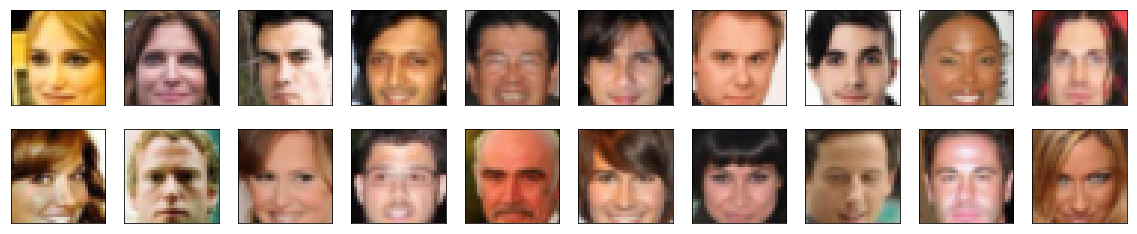

In [8]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max = feature_range
    x = (max-min)*x + min    
    return x


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [11]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3,conv_dim, kernel_size=4,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,kernel_size=4,batch_norm=False)
        self.conv3 = conv(conv_dim*2,conv_dim*4,kernel_size=4)
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.conv2(x),0.2)
        x = F.leaky_relu(self.conv3(x),0.2)
        
        # flatten
        out = x.view(-1, self.conv_dim*4*4*4)
                    
        out = self.fc(out)        
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size,conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1,self.conv_dim*4,4,4)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.tanh(self.t_conv3(out))
        
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
# def init_weights(net, init_type='normal', init_gain=0.02):
#     """Initialize network weights.
#     Parameters:
#         net (network)   -- network to be initialized
#         init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
#         init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
#     We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
#     work better for some applications. Feel free to try yourself.
#     """
#     def init_func(m):  # define the initialization function
#         classname = m.__class__.__name__
#         if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
#             if init_type == 'normal':
#                 init.normal_(m.weight.data, 0.0, init_gain)
#             elif init_type == 'xavier':
#                 init.xavier_normal_(m.weight.data, gain=init_gain)
#             elif init_type == 'kaiming':
#                 init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
#             elif init_type == 'orthogonal':
#                 init.orthogonal_(m.weight.data, gain=init_gain)
#             else:
#                 raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
#             if hasattr(m, 'bias') and m.bias is not None:
#                 init.constant_(m.bias.data, 0.0)
#         elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
#             init.normal_(m.weight.data, 1.0, init_gain)
#             init.constant_(m.bias.data, 0.0)

#     print('initialize network with %s' % init_type)
#     net.apply(init_func)  # apply the initialization function <init_func>

In [16]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    std_dev=0.02
    classname = m.__class__.__name__
    
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, std_dev)
   
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [18]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D.cuda()
    G.cuda()

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [20]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [21]:
import torch.optim as optim

# params
lr = 0.0001
beta1=0.1
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real) 
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake) 
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.6031 | g_loss: 0.8115
Epoch [    1/   50] | d_loss: 0.6823 | g_loss: 1.0844
Epoch [    1/   50] | d_loss: 0.5162 | g_loss: 1.8254
Epoch [    1/   50] | d_loss: 0.4683 | g_loss: 1.4759
Epoch [    1/   50] | d_loss: 0.5353 | g_loss: 1.6441
Epoch [    1/   50] | d_loss: 0.4579 | g_loss: 1.5352
Epoch [    1/   50] | d_loss: 0.7222 | g_loss: 0.9510
Epoch [    1/   50] | d_loss: 0.6381 | g_loss: 1.2269
Epoch [    1/   50] | d_loss: 0.6264 | g_loss: 1.4840
Epoch [    1/   50] | d_loss: 0.7149 | g_loss: 1.0863
Epoch [    1/   50] | d_loss: 0.6712 | g_loss: 1.3990
Epoch [    1/   50] | d_loss: 0.7490 | g_loss: 1.2628
Epoch [    1/   50] | d_loss: 0.7358 | g_loss: 1.4600
Epoch [    1/   50] | d_loss: 0.8211 | g_loss: 1.2961
Epoch [    1/   50] | d_loss: 0.7638 | g_loss: 1.5553
Epoch [    1/   50] | d_loss: 1.1440 | g_loss: 1.6328
Epoch [    1/   50] | d_loss: 0.7268 | g_loss: 1.7545
Epoch [    1/   50] | d_loss: 0.7005 | g_loss: 1.3091
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.0731 | g_loss: 0.8821
Epoch [    3/   50] | d_loss: 1.0833 | g_loss: 0.7485
Epoch [    3/   50] | d_loss: 0.9381 | g_loss: 0.8058
Epoch [    3/   50] | d_loss: 0.9630 | g_loss: 0.9976
Epoch [    3/   50] | d_loss: 1.2128 | g_loss: 0.9726
Epoch [    3/   50] | d_loss: 1.0667 | g_loss: 0.6135
Epoch [    3/   50] | d_loss: 1.0384 | g_loss: 1.1147
Epoch [    3/   50] | d_loss: 0.8804 | g_loss: 0.8550
Epoch [    3/   50] | d_loss: 1.0802 | g_loss: 1.1539
Epoch [    3/   50] | d_loss: 1.0480 | g_loss: 0.9901
Epoch [    3/   50] | d_loss: 0.9757 | g_loss: 1.4176
Epoch [    3/   50] | d_loss: 0.9817 | g_loss: 0.9116
Epoch [    3/   50] | d_loss: 1.2246 | g_loss: 0.7959
Epoch [    3/   50] | d_loss: 0.9842 | g_loss: 1.5391
Epoch [    3/   50] | d_loss: 1.1156 | g_loss: 1.4777
Epoch [    3/   50] | d_loss: 0.9673 | g_loss: 1.4229
Epoch [    3/   50] | d_loss: 0.9508 | g_loss: 0.9233
Epoch [    3/   50] | d_loss: 0.8544 | g_loss: 1.2439
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 1.1946 | g_loss: 0.9607
Epoch [    6/   50] | d_loss: 1.0066 | g_loss: 0.7595
Epoch [    6/   50] | d_loss: 1.1848 | g_loss: 0.9258
Epoch [    6/   50] | d_loss: 0.8152 | g_loss: 1.0407
Epoch [    6/   50] | d_loss: 0.7187 | g_loss: 1.1957
Epoch [    6/   50] | d_loss: 0.9131 | g_loss: 1.8075
Epoch [    6/   50] | d_loss: 1.0326 | g_loss: 1.2251
Epoch [    6/   50] | d_loss: 0.8174 | g_loss: 1.2606
Epoch [    6/   50] | d_loss: 1.0350 | g_loss: 1.2074
Epoch [    6/   50] | d_loss: 1.0164 | g_loss: 1.2046
Epoch [    6/   50] | d_loss: 1.0968 | g_loss: 0.5999
Epoch [    6/   50] | d_loss: 0.8874 | g_loss: 1.1097
Epoch [    6/   50] | d_loss: 0.8836 | g_loss: 0.8731
Epoch [    6/   50] | d_loss: 0.9781 | g_loss: 1.4382
Epoch [    6/   50] | d_loss: 1.0979 | g_loss: 0.9626
Epoch [    6/   50] | d_loss: 1.0792 | g_loss: 0.7460
Epoch [    6/   50] | d_loss: 0.8962 | g_loss: 1.2068
Epoch [    6/   50] | d_loss: 1.1117 | g_loss: 1.6910
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 1.2445 | g_loss: 1.8335
Epoch [    9/   50] | d_loss: 1.1118 | g_loss: 1.5163
Epoch [    9/   50] | d_loss: 0.8746 | g_loss: 1.0000
Epoch [    9/   50] | d_loss: 0.8443 | g_loss: 1.2245
Epoch [    9/   50] | d_loss: 0.8753 | g_loss: 1.1969
Epoch [    9/   50] | d_loss: 0.9291 | g_loss: 1.1474
Epoch [    9/   50] | d_loss: 0.9305 | g_loss: 0.9881
Epoch [    9/   50] | d_loss: 0.9907 | g_loss: 1.3043
Epoch [    9/   50] | d_loss: 0.8709 | g_loss: 1.1971
Epoch [    9/   50] | d_loss: 0.7645 | g_loss: 1.7965
Epoch [    9/   50] | d_loss: 0.9537 | g_loss: 1.2857
Epoch [    9/   50] | d_loss: 1.0120 | g_loss: 1.1304
Epoch [    9/   50] | d_loss: 0.8129 | g_loss: 1.3227
Epoch [    9/   50] | d_loss: 0.6050 | g_loss: 1.3089
Epoch [    9/   50] | d_loss: 1.1318 | g_loss: 1.8567
Epoch [    9/   50] | d_loss: 0.8292 | g_loss: 2.0080
Epoch [    9/   50] | d_loss: 0.7728 | g_loss: 1.2788
Epoch [    9/   50] | d_loss: 0.4927 | g_loss: 1.7678
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.7876 | g_loss: 2.0489
Epoch [   11/   50] | d_loss: 0.7903 | g_loss: 1.2273
Epoch [   11/   50] | d_loss: 0.8910 | g_loss: 0.7797
Epoch [   11/   50] | d_loss: 0.9274 | g_loss: 1.6801
Epoch [   11/   50] | d_loss: 0.8475 | g_loss: 0.7195
Epoch [   11/   50] | d_loss: 0.8425 | g_loss: 2.3546
Epoch [   11/   50] | d_loss: 0.8049 | g_loss: 1.3704
Epoch [   11/   50] | d_loss: 1.2284 | g_loss: 0.9326
Epoch [   11/   50] | d_loss: 0.6244 | g_loss: 1.6114
Epoch [   11/   50] | d_loss: 0.8083 | g_loss: 0.7175
Epoch [   11/   50] | d_loss: 0.7835 | g_loss: 1.0357
Epoch [   11/   50] | d_loss: 0.7911 | g_loss: 1.5472
Epoch [   11/   50] | d_loss: 1.0800 | g_loss: 1.2640
Epoch [   11/   50] | d_loss: 0.7067 | g_loss: 1.2425
Epoch [   11/   50] | d_loss: 0.6677 | g_loss: 1.8105
Epoch [   11/   50] | d_loss: 0.7356 | g_loss: 1.5976
Epoch [   11/   50] | d_loss: 0.6105 | g_loss: 1.6677
Epoch [   11/   50] | d_loss: 0.6077 | g_loss: 1.4805
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.4852 | g_loss: 1.6888
Epoch [   14/   50] | d_loss: 0.8303 | g_loss: 1.9336
Epoch [   14/   50] | d_loss: 0.8523 | g_loss: 1.4333
Epoch [   14/   50] | d_loss: 0.6806 | g_loss: 0.9309
Epoch [   14/   50] | d_loss: 0.6612 | g_loss: 1.0756
Epoch [   14/   50] | d_loss: 0.7904 | g_loss: 1.5403
Epoch [   14/   50] | d_loss: 0.7389 | g_loss: 1.7058
Epoch [   14/   50] | d_loss: 0.4982 | g_loss: 1.6378
Epoch [   14/   50] | d_loss: 0.5926 | g_loss: 1.4091
Epoch [   14/   50] | d_loss: 0.7279 | g_loss: 1.7355
Epoch [   14/   50] | d_loss: 0.9849 | g_loss: 1.3914
Epoch [   14/   50] | d_loss: 0.6940 | g_loss: 1.8475
Epoch [   14/   50] | d_loss: 0.6853 | g_loss: 1.0584
Epoch [   14/   50] | d_loss: 0.6208 | g_loss: 0.6690
Epoch [   14/   50] | d_loss: 0.7834 | g_loss: 1.5111
Epoch [   14/   50] | d_loss: 0.7757 | g_loss: 1.5369
Epoch [   14/   50] | d_loss: 0.8171 | g_loss: 1.9237
Epoch [   14/   50] | d_loss: 0.6699 | g_loss: 1.8224
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 1.2630 | g_loss: 2.8112
Epoch [   17/   50] | d_loss: 0.7311 | g_loss: 1.4852
Epoch [   17/   50] | d_loss: 0.7488 | g_loss: 1.5620
Epoch [   17/   50] | d_loss: 0.8559 | g_loss: 0.9537
Epoch [   17/   50] | d_loss: 0.3305 | g_loss: 1.8397
Epoch [   17/   50] | d_loss: 0.5953 | g_loss: 1.6143
Epoch [   17/   50] | d_loss: 0.5049 | g_loss: 2.4965
Epoch [   17/   50] | d_loss: 0.2411 | g_loss: 2.6506
Epoch [   17/   50] | d_loss: 1.0749 | g_loss: 2.8930
Epoch [   17/   50] | d_loss: 0.4726 | g_loss: 2.0998
Epoch [   17/   50] | d_loss: 0.5679 | g_loss: 0.7290
Epoch [   17/   50] | d_loss: 0.6502 | g_loss: 1.7759
Epoch [   17/   50] | d_loss: 0.3677 | g_loss: 2.3227
Epoch [   17/   50] | d_loss: 0.8178 | g_loss: 1.3657
Epoch [   17/   50] | d_loss: 0.3707 | g_loss: 2.7576
Epoch [   17/   50] | d_loss: 0.6294 | g_loss: 2.1758
Epoch [   17/   50] | d_loss: 0.5301 | g_loss: 1.7185
Epoch [   17/   50] | d_loss: 0.6953 | g_loss: 1.5617
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.6708 | g_loss: 1.9081
Epoch [   19/   50] | d_loss: 0.5959 | g_loss: 2.0074
Epoch [   19/   50] | d_loss: 0.7756 | g_loss: 1.9570
Epoch [   19/   50] | d_loss: 0.5519 | g_loss: 2.0179
Epoch [   19/   50] | d_loss: 0.3423 | g_loss: 2.4416
Epoch [   19/   50] | d_loss: 0.6936 | g_loss: 1.9299
Epoch [   19/   50] | d_loss: 0.4425 | g_loss: 2.0608
Epoch [   19/   50] | d_loss: 0.7393 | g_loss: 2.6947
Epoch [   19/   50] | d_loss: 0.8155 | g_loss: 2.1863
Epoch [   19/   50] | d_loss: 0.4485 | g_loss: 3.4229
Epoch [   19/   50] | d_loss: 0.5834 | g_loss: 1.9353
Epoch [   19/   50] | d_loss: 0.8068 | g_loss: 1.9535
Epoch [   19/   50] | d_loss: 0.5036 | g_loss: 1.7450
Epoch [   19/   50] | d_loss: 0.3539 | g_loss: 2.0080
Epoch [   19/   50] | d_loss: 0.8945 | g_loss: 0.8667
Epoch [   19/   50] | d_loss: 1.0379 | g_loss: 1.3640
Epoch [   19/   50] | d_loss: 0.6772 | g_loss: 1.5344
Epoch [   19/   50] | d_loss: 0.5051 | g_loss: 0.4652
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.7645 | g_loss: 2.0044
Epoch [   22/   50] | d_loss: 0.7122 | g_loss: 0.8341
Epoch [   22/   50] | d_loss: 0.4130 | g_loss: 1.5899
Epoch [   22/   50] | d_loss: 0.7710 | g_loss: 2.4043
Epoch [   22/   50] | d_loss: 0.5153 | g_loss: 2.8151
Epoch [   22/   50] | d_loss: 0.6998 | g_loss: 3.2231
Epoch [   22/   50] | d_loss: 0.4502 | g_loss: 3.2283
Epoch [   22/   50] | d_loss: 0.8486 | g_loss: 1.1148
Epoch [   22/   50] | d_loss: 0.5029 | g_loss: 1.9912
Epoch [   22/   50] | d_loss: 0.9004 | g_loss: 0.6054
Epoch [   22/   50] | d_loss: 0.9038 | g_loss: 1.3646
Epoch [   22/   50] | d_loss: 1.0040 | g_loss: 2.0867
Epoch [   22/   50] | d_loss: 1.1023 | g_loss: 1.1214
Epoch [   22/   50] | d_loss: 0.4174 | g_loss: 1.4690
Epoch [   22/   50] | d_loss: 0.4037 | g_loss: 1.5010
Epoch [   22/   50] | d_loss: 0.3490 | g_loss: 1.9871
Epoch [   22/   50] | d_loss: 0.5562 | g_loss: 1.5468
Epoch [   22/   50] | d_loss: 0.4133 | g_loss: 2.3048
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.4592 | g_loss: 2.9993
Epoch [   25/   50] | d_loss: 0.9388 | g_loss: 1.6042
Epoch [   25/   50] | d_loss: 0.5004 | g_loss: 2.8503
Epoch [   25/   50] | d_loss: 0.6391 | g_loss: 1.3790
Epoch [   25/   50] | d_loss: 0.6944 | g_loss: 1.6079
Epoch [   25/   50] | d_loss: 0.5327 | g_loss: 1.3660
Epoch [   25/   50] | d_loss: 0.4275 | g_loss: 1.4875
Epoch [   25/   50] | d_loss: 0.6263 | g_loss: 3.2872
Epoch [   25/   50] | d_loss: 0.6107 | g_loss: 1.6551
Epoch [   25/   50] | d_loss: 0.4897 | g_loss: 3.4796
Epoch [   25/   50] | d_loss: 0.4875 | g_loss: 1.5472
Epoch [   25/   50] | d_loss: 0.4207 | g_loss: 2.2836
Epoch [   25/   50] | d_loss: 0.6888 | g_loss: 2.3418
Epoch [   25/   50] | d_loss: 0.6150 | g_loss: 2.4414
Epoch [   25/   50] | d_loss: 0.3761 | g_loss: 1.9031
Epoch [   25/   50] | d_loss: 0.4568 | g_loss: 2.3421
Epoch [   25/   50] | d_loss: 0.2985 | g_loss: 1.9115
Epoch [   25/   50] | d_loss: 1.1833 | g_loss: 1.8417
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.5009 | g_loss: 1.8869
Epoch [   27/   50] | d_loss: 0.6089 | g_loss: 2.9072
Epoch [   27/   50] | d_loss: 1.0979 | g_loss: 1.7925
Epoch [   27/   50] | d_loss: 0.6744 | g_loss: 2.5308
Epoch [   27/   50] | d_loss: 0.2996 | g_loss: 2.7945
Epoch [   27/   50] | d_loss: 0.3777 | g_loss: 2.1755
Epoch [   27/   50] | d_loss: 0.4518 | g_loss: 1.7067
Epoch [   27/   50] | d_loss: 0.6268 | g_loss: 1.4303
Epoch [   27/   50] | d_loss: 0.3303 | g_loss: 3.0135
Epoch [   27/   50] | d_loss: 0.3062 | g_loss: 2.6723
Epoch [   27/   50] | d_loss: 0.3840 | g_loss: 2.8750
Epoch [   27/   50] | d_loss: 0.2850 | g_loss: 2.4070
Epoch [   27/   50] | d_loss: 0.4177 | g_loss: 2.4346
Epoch [   27/   50] | d_loss: 1.3138 | g_loss: 3.5501
Epoch [   27/   50] | d_loss: 0.3584 | g_loss: 2.8983
Epoch [   27/   50] | d_loss: 0.8028 | g_loss: 1.5554
Epoch [   27/   50] | d_loss: 0.5379 | g_loss: 1.9984
Epoch [   27/   50] | d_loss: 0.7207 | g_loss: 1.1941
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.7210 | g_loss: 1.5944
Epoch [   30/   50] | d_loss: 0.3498 | g_loss: 1.8962
Epoch [   30/   50] | d_loss: 0.3657 | g_loss: 2.5789
Epoch [   30/   50] | d_loss: 0.3109 | g_loss: 2.9928
Epoch [   30/   50] | d_loss: 0.5464 | g_loss: 1.4512
Epoch [   30/   50] | d_loss: 0.6681 | g_loss: 0.9683
Epoch [   30/   50] | d_loss: 0.4086 | g_loss: 1.8276
Epoch [   30/   50] | d_loss: 0.4152 | g_loss: 1.9579
Epoch [   30/   50] | d_loss: 0.4210 | g_loss: 2.2845
Epoch [   30/   50] | d_loss: 0.5286 | g_loss: 1.6520
Epoch [   30/   50] | d_loss: 0.4974 | g_loss: 1.9852
Epoch [   30/   50] | d_loss: 0.6190 | g_loss: 2.5210
Epoch [   30/   50] | d_loss: 1.1117 | g_loss: 1.0730
Epoch [   30/   50] | d_loss: 0.6007 | g_loss: 2.0403
Epoch [   30/   50] | d_loss: 0.3633 | g_loss: 1.7203
Epoch [   30/   50] | d_loss: 0.4374 | g_loss: 2.8861
Epoch [   30/   50] | d_loss: 0.3437 | g_loss: 2.6857
Epoch [   30/   50] | d_loss: 0.3976 | g_loss: 2.8025
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.8530 | g_loss: 1.7456
Epoch [   33/   50] | d_loss: 0.2591 | g_loss: 2.5447
Epoch [   33/   50] | d_loss: 1.1151 | g_loss: 1.9467
Epoch [   33/   50] | d_loss: 0.3937 | g_loss: 2.6591
Epoch [   33/   50] | d_loss: 0.3373 | g_loss: 1.8338
Epoch [   33/   50] | d_loss: 0.4255 | g_loss: 3.0559
Epoch [   33/   50] | d_loss: 0.6340 | g_loss: 3.1480
Epoch [   33/   50] | d_loss: 0.3852 | g_loss: 3.3856
Epoch [   33/   50] | d_loss: 2.7545 | g_loss: 5.3472
Epoch [   33/   50] | d_loss: 0.5258 | g_loss: 2.1779
Epoch [   33/   50] | d_loss: 0.6046 | g_loss: 1.5825
Epoch [   33/   50] | d_loss: 1.5442 | g_loss: 4.7939
Epoch [   33/   50] | d_loss: 0.3026 | g_loss: 2.9092
Epoch [   33/   50] | d_loss: 0.3250 | g_loss: 3.2069
Epoch [   33/   50] | d_loss: 0.3642 | g_loss: 2.6334
Epoch [   33/   50] | d_loss: 0.3400 | g_loss: 2.7784
Epoch [   33/   50] | d_loss: 0.2459 | g_loss: 2.2600
Epoch [   33/   50] | d_loss: 0.6355 | g_loss: 3.5569
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.3824 | g_loss: 2.1520
Epoch [   35/   50] | d_loss: 1.0355 | g_loss: 0.9786
Epoch [   35/   50] | d_loss: 0.1732 | g_loss: 2.2904
Epoch [   35/   50] | d_loss: 0.2788 | g_loss: 3.7847
Epoch [   35/   50] | d_loss: 0.5645 | g_loss: 2.4434
Epoch [   35/   50] | d_loss: 0.6150 | g_loss: 2.6481
Epoch [   35/   50] | d_loss: 0.4854 | g_loss: 3.2398
Epoch [   35/   50] | d_loss: 0.6935 | g_loss: 1.3037
Epoch [   35/   50] | d_loss: 0.2903 | g_loss: 2.7499
Epoch [   35/   50] | d_loss: 0.1478 | g_loss: 3.6240
Epoch [   35/   50] | d_loss: 0.6447 | g_loss: 3.8167
Epoch [   35/   50] | d_loss: 0.3450 | g_loss: 1.9634
Epoch [   35/   50] | d_loss: 0.4001 | g_loss: 2.4490
Epoch [   35/   50] | d_loss: 0.8302 | g_loss: 1.3073
Epoch [   35/   50] | d_loss: 0.4466 | g_loss: 2.6010
Epoch [   35/   50] | d_loss: 0.6593 | g_loss: 1.6470
Epoch [   35/   50] | d_loss: 0.3768 | g_loss: 1.8102
Epoch [   35/   50] | d_loss: 0.5987 | g_loss: 2.0763
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.2750 | g_loss: 2.1535
Epoch [   38/   50] | d_loss: 0.2123 | g_loss: 2.8127
Epoch [   38/   50] | d_loss: 0.1783 | g_loss: 3.1931
Epoch [   38/   50] | d_loss: 0.3562 | g_loss: 3.2161
Epoch [   38/   50] | d_loss: 0.1562 | g_loss: 2.2384
Epoch [   38/   50] | d_loss: 0.4243 | g_loss: 2.9985
Epoch [   38/   50] | d_loss: 0.5056 | g_loss: 3.8277
Epoch [   38/   50] | d_loss: 0.5222 | g_loss: 1.7902
Epoch [   38/   50] | d_loss: 0.4226 | g_loss: 2.7927
Epoch [   38/   50] | d_loss: 0.3029 | g_loss: 1.7308
Epoch [   38/   50] | d_loss: 0.4106 | g_loss: 1.6606
Epoch [   38/   50] | d_loss: 0.4973 | g_loss: 2.7067
Epoch [   38/   50] | d_loss: 1.5136 | g_loss: 5.1136
Epoch [   38/   50] | d_loss: 0.5605 | g_loss: 2.1154
Epoch [   38/   50] | d_loss: 0.4381 | g_loss: 2.3318
Epoch [   38/   50] | d_loss: 0.6107 | g_loss: 2.4366
Epoch [   38/   50] | d_loss: 0.4717 | g_loss: 2.5866
Epoch [   38/   50] | d_loss: 0.5971 | g_loss: 1.7734
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.3315 | g_loss: 2.2556
Epoch [   41/   50] | d_loss: 0.5147 | g_loss: 2.4672
Epoch [   41/   50] | d_loss: 0.4666 | g_loss: 3.3629
Epoch [   41/   50] | d_loss: 0.3192 | g_loss: 1.8448
Epoch [   41/   50] | d_loss: 0.2903 | g_loss: 2.8504
Epoch [   41/   50] | d_loss: 0.2986 | g_loss: 2.5553
Epoch [   41/   50] | d_loss: 0.4514 | g_loss: 1.9997
Epoch [   41/   50] | d_loss: 0.5003 | g_loss: 3.3094
Epoch [   41/   50] | d_loss: 0.4245 | g_loss: 4.1536
Epoch [   41/   50] | d_loss: 0.5702 | g_loss: 1.8536
Epoch [   41/   50] | d_loss: 0.3594 | g_loss: 2.3753
Epoch [   41/   50] | d_loss: 0.3201 | g_loss: 3.0387
Epoch [   41/   50] | d_loss: 0.4810 | g_loss: 3.1057
Epoch [   41/   50] | d_loss: 0.4542 | g_loss: 2.2111
Epoch [   41/   50] | d_loss: 0.3924 | g_loss: 2.7687
Epoch [   41/   50] | d_loss: 0.3541 | g_loss: 2.8113
Epoch [   41/   50] | d_loss: 0.2440 | g_loss: 2.7726
Epoch [   41/   50] | d_loss: 0.1679 | g_loss: 2.1050
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.3367 | g_loss: 1.7046
Epoch [   43/   50] | d_loss: 1.2140 | g_loss: 5.5808
Epoch [   43/   50] | d_loss: 1.0814 | g_loss: 1.3260
Epoch [   43/   50] | d_loss: 0.2827 | g_loss: 1.3757
Epoch [   43/   50] | d_loss: 0.7824 | g_loss: 1.6320
Epoch [   43/   50] | d_loss: 0.2246 | g_loss: 2.1616
Epoch [   43/   50] | d_loss: 0.2044 | g_loss: 3.5010
Epoch [   43/   50] | d_loss: 0.2063 | g_loss: 3.6234
Epoch [   43/   50] | d_loss: 0.9477 | g_loss: 3.7927
Epoch [   43/   50] | d_loss: 0.6122 | g_loss: 3.5256
Epoch [   43/   50] | d_loss: 0.3462 | g_loss: 1.2281
Epoch [   43/   50] | d_loss: 0.4308 | g_loss: 1.9378
Epoch [   43/   50] | d_loss: 0.3979 | g_loss: 1.0338
Epoch [   43/   50] | d_loss: 0.4410 | g_loss: 1.9679
Epoch [   43/   50] | d_loss: 0.3728 | g_loss: 2.4028
Epoch [   43/   50] | d_loss: 0.2265 | g_loss: 3.5775
Epoch [   43/   50] | d_loss: 0.2907 | g_loss: 3.1431
Epoch [   43/   50] | d_loss: 0.8249 | g_loss: 0.9063
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.2899 | g_loss: 2.9995
Epoch [   46/   50] | d_loss: 0.3900 | g_loss: 3.4569
Epoch [   46/   50] | d_loss: 0.2279 | g_loss: 3.1787
Epoch [   46/   50] | d_loss: 0.2386 | g_loss: 1.8276
Epoch [   46/   50] | d_loss: 0.6760 | g_loss: 2.5297
Epoch [   46/   50] | d_loss: 0.6789 | g_loss: 1.7120
Epoch [   46/   50] | d_loss: 0.1765 | g_loss: 2.8751
Epoch [   46/   50] | d_loss: 0.3213 | g_loss: 4.4645
Epoch [   46/   50] | d_loss: 0.2049 | g_loss: 2.7235
Epoch [   46/   50] | d_loss: 0.1527 | g_loss: 3.9632
Epoch [   46/   50] | d_loss: 0.3026 | g_loss: 3.2279
Epoch [   46/   50] | d_loss: 0.3819 | g_loss: 2.8887
Epoch [   46/   50] | d_loss: 0.9619 | g_loss: 0.2184
Epoch [   46/   50] | d_loss: 0.2764 | g_loss: 2.3826
Epoch [   46/   50] | d_loss: 0.2574 | g_loss: 3.8356
Epoch [   46/   50] | d_loss: 0.5756 | g_loss: 1.9173
Epoch [   46/   50] | d_loss: 0.1561 | g_loss: 3.9162
Epoch [   46/   50] | d_loss: 0.4697 | g_loss: 4.9338
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.2215 | g_loss: 3.3783
Epoch [   49/   50] | d_loss: 0.1598 | g_loss: 3.8431
Epoch [   49/   50] | d_loss: 0.2696 | g_loss: 3.3067
Epoch [   49/   50] | d_loss: 0.9831 | g_loss: 3.7683
Epoch [   49/   50] | d_loss: 0.2575 | g_loss: 2.8462
Epoch [   49/   50] | d_loss: 0.1037 | g_loss: 3.9834
Epoch [   49/   50] | d_loss: 0.0829 | g_loss: 3.6517
Epoch [   49/   50] | d_loss: 0.5509 | g_loss: 0.8805
Epoch [   49/   50] | d_loss: 0.1375 | g_loss: 3.8896
Epoch [   49/   50] | d_loss: 0.3073 | g_loss: 2.3165
Epoch [   49/   50] | d_loss: 0.1226 | g_loss: 4.4250
Epoch [   49/   50] | d_loss: 0.7401 | g_loss: 3.4045
Epoch [   49/   50] | d_loss: 0.4004 | g_loss: 2.8942
Epoch [   49/   50] | d_loss: 0.8081 | g_loss: 3.7045
Epoch [   49/   50] | d_loss: 0.2049 | g_loss: 2.9375
Epoch [   49/   50] | d_loss: 0.3831 | g_loss: 2.2844
Epoch [   49/   50] | d_loss: 0.3877 | g_loss: 2.8940
Epoch [   49/   50] | d_loss: 0.1715 | g_loss: 2.3807
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

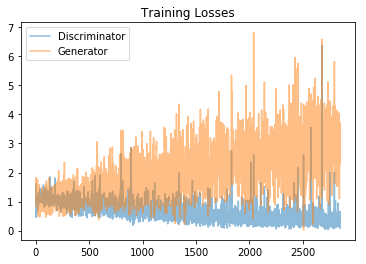

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

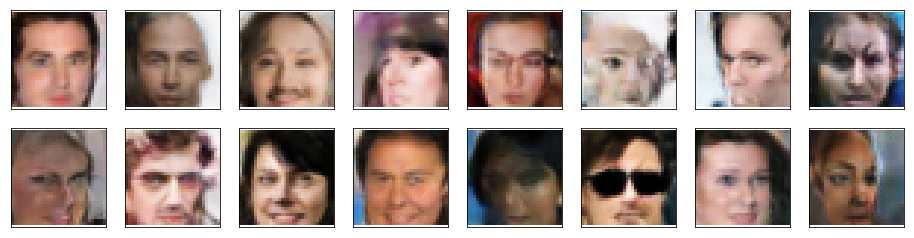

In [27]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
1.Sample images does look like faces
2.However the faces look like they have been made by putting together multiple different faces
3.They also seem to be a little distorted.
I believe we could probably get better results by training for longer periors of time(more epochs) and improving the depth of the GAN that we are trying to build. I guess we can also try to include a better mix of people with different colors in order to train the Generator to come up with right mix of features belonging to the same color

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.